## Exercise

### 1. Load Data
Loading up data of `torchvision.datasets.CIFAR10` (Canadian Institute For Advanced Research) Datasets which contains *60,000 32x32* color images in *10* different classes.

In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import torchvision.transforms.functional as F   # Convert to PIL Image using torchvision.transforms.functional

print(torch.__version__)
print(torchvision.__version__)

# Setting up device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

2.1.0+cu121
0.16.0+cu121
cuda


In [2]:
train_data = datasets.CIFAR10(root = "data",
                              train = True,
                              download = True,
                              transform = torchvision.transforms.ToTensor(),
                              target_transform = None)

test_data = datasets.CIFAR10(root = "data",
                             train = False,
                             download = True,
                             transform = torchvision.transforms.ToTensor(),
                             target_transform = None)

100%|██████████| 170498071/170498071 [00:05<00:00, 28629807.44it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [3]:
len(train_data), len(test_data)

(50000, 10000)

In [4]:
# Sample image
image, label = train_data[0]
image.shape, label

(torch.Size([3, 32, 32]), 6)

### 2. Mapping dictionary index to `class_labels`

In [5]:
class_name = train_data.classes
class_name, len(class_name)

(['airplane',
  'automobile',
  'bird',
  'cat',
  'deer',
  'dog',
  'frog',
  'horse',
  'ship',
  'truck'],
 10)

In [6]:
class_to_idx = train_data.class_to_idx
class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [7]:
# Input and Ouput Shapes
image.shape, class_name[label], label

(torch.Size([3, 32, 32]), 'frog', 6)

From the shape of sample image of frog, it seems the image contains

`[color_channels=3, height=32, width=32]`

### 3. Visualizing the image

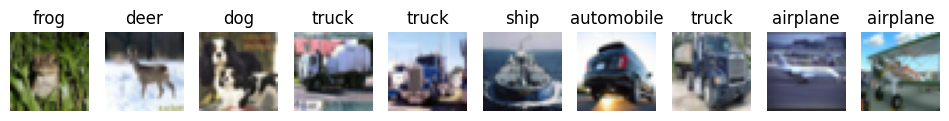

In [64]:
fig = plt.figure(figsize = (12, 5))
rows, cols = 1, 10

for i in range(1, rows*cols + 1):
  random_idx = torch.randint(0, len(train_data), size = [1]).item()
  image, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(F.to_pil_image(image))
  plt.title(class_name[label])
  plt.axis(False);

### 4. Turn CIFAR10 train and test datasets into Dataloaders

In [65]:
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_dataloader = DataLoader(dataset = train_data,
                              batch_size = BATCH_SIZE,
                              shuffle = True)

test_dataloader = DataLoader(dataset = test_data,
                             batch_size = BATCH_SIZE,
                             shuffle = True)

len(train_dataloader), len(test_dataloader)

(1563, 313)

### 5. Build Model class

In [66]:
import torch.nn as nn

class CIFAR10Model(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super(CIFAR10Model, self).__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(input_shape, hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(hidden_units),
            nn.Dropout(0.2)  # Dropout for regularization
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, 2 * hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(2 * hidden_units, 2 * hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(2 * hidden_units),
            nn.Dropout(0.2)
        )
        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(2 * hidden_units, 4 * hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(4 * hidden_units, output_shape, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(output_shape),
            nn.Dropout(0.2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(4 * 4 * output_shape, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, output_shape)
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.conv_block_3(x)
        x = self.classifier(x)
        return x

In [67]:
model = CIFAR10Model(3, 10, len(class_name)).to(device)
model, next(model.parameters()).device

(CIFAR10Model(
   (conv_block_1): Sequential(
     (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (3): ReLU()
     (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (5): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (6): Dropout(p=0.2, inplace=False)
   )
   (conv_block_2): Sequential(
     (0): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (1): ReLU()
     (2): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     (3): ReLU()
     (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
     (5): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (6): Dropout(p=0.2, inplace=False)
   )
   (conv_block_3): Sequential(
     (0): Conv2d(20, 40, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     

### 6. Train and Test CIFAR10 Dataloaders

In [68]:
!pip install torchmetrics

In [69]:
# Import Accuracy
from torchmetrics import Accuracy

torchmetrics_accuracy = Accuracy(task = "multiclass",
                                 num_classes = len(class_name)).to(device)

In [70]:
# Setting up loss_fn and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = 0.001,)

In [71]:
# Train and Test function
def train_step(model, data_loader, loss_fn, optimizer, accuracy, device):
  train_loss, train_acc = 0, 0

  model.to(device)
  train_losses = []
  train_accuracies = []
  for batch, (X, y) in enumerate(data_loader):
    X, y = X.to(device), y.to(device)
    y_pred = model(X)
    loss = loss_fn(y_pred, y)
    train_loss += loss
    train_acc += torchmetrics_accuracy(y,
                                       y_pred.argmax(dim = 1)) * 100
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  train_losses.append(train_loss.item())
  train_accuracies.append(train_acc.item())
  print(f'Train loss: {train_loss:.4f} ---- Train acc: {train_acc:.2f}%')
  return train_losses, train_accuracies

def test_step(model, data_loader, loss_fn, optimizer, accuracy, device):
  test_loss, test_acc = 0, 0
  model.to(device)
  model.eval()
  test_losses = []
  test_accuracies = []

  with torch.inference_mode():
    for X_test, y_test in data_loader:
      X_test, y_test = X_test.to(device), y_test.to(device)
      test_pred = model(X_test)
      loss = loss_fn(test_pred, y_test)
      test_loss += loss
      test_acc += torchmetrics_accuracy(y_test,
                                        test_pred.argmax(dim = 1)) * 100

    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    test_losses.append(test_loss.item())
    test_accuracies.append(test_acc.item())
    print(f'Test loss: {test_loss:.4f} ---- Test acc: {test_acc:.2f}%')
  return test_losses, test_accuracies

In [72]:
torch.manual_seed(42)

from tqdm.auto import tqdm

epochs = 10
train_losses_history = []
train_accuracies_history = []
test_losses_history = []
test_accuracies_history = []

for epoch in tqdm(range(epochs)):
  print(f'Epoch: {epoch}')
  train_losses, train_accuracies = train_step(model, train_dataloader, loss_fn, optimizer,
                                              torchmetrics_accuracy, device)
  test_losses, test_accuracies = test_step(model, test_dataloader, loss_fn, optimizer,
                                           torchmetrics_accuracy, device)

  # Calculate avg. loss and accuracy
  avg_train_loss = sum(train_losses) / len(train_losses)
  avg_train_accuracy = sum(train_accuracies) / len(train_accuracies)
  avg_test_loss = sum(test_losses) / len(test_losses)
  avg_test_accuracy = sum(test_accuracies) / len(test_accuracies)

  train_losses_history.append(avg_train_loss)
  train_accuracies_history.append(avg_train_accuracy)
  test_losses_history.append(avg_test_loss)
  test_accuracies_history.append(avg_test_accuracy)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
Train loss: 1.5495 ---- Train acc: 42.88%
Test loss: 1.2155 ---- Test acc: 55.70%
Epoch: 1
Train loss: 1.1223 ---- Train acc: 59.54%
Test loss: 1.0551 ---- Test acc: 62.03%
Epoch: 2
Train loss: 0.9397 ---- Train acc: 66.74%
Test loss: 0.9617 ---- Test acc: 65.92%
Epoch: 3
Train loss: 0.8341 ---- Train acc: 70.45%
Test loss: 0.8888 ---- Test acc: 68.77%
Epoch: 4
Train loss: 0.7674 ---- Train acc: 72.82%
Test loss: 0.8721 ---- Test acc: 69.74%
Epoch: 5
Train loss: 0.7081 ---- Train acc: 74.92%
Test loss: 0.8582 ---- Test acc: 70.40%
Epoch: 6
Train loss: 0.6588 ---- Train acc: 76.81%
Test loss: 0.8314 ---- Test acc: 70.51%
Epoch: 7
Train loss: 0.6207 ---- Train acc: 78.13%
Test loss: 0.8253 ---- Test acc: 72.46%
Epoch: 8
Train loss: 0.5809 ---- Train acc: 79.38%
Test loss: 0.8674 ---- Test acc: 71.18%
Epoch: 9
Train loss: 0.5476 ---- Train acc: 80.52%
Test loss: 0.8400 ---- Test acc: 72.27%


### 7. Loss Curves and Accuracy Curves

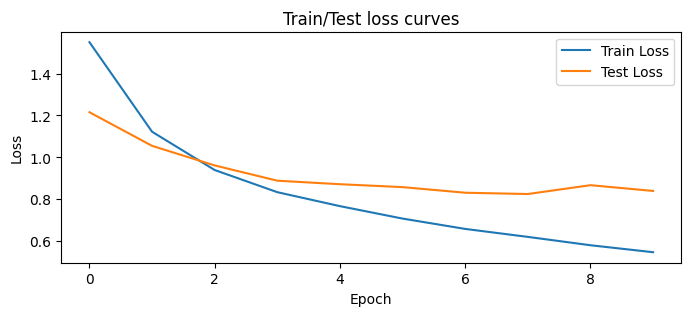

In [89]:
# Plot loss curves
epoch = np.arange(0, len(train_losses_history))

plt.figure(figsize=(8, 3))
plt.plot(epoch, train_losses_history, label="Train Loss")
plt.plot(epoch, test_losses_history, label="Test Loss")
plt.title("Train/Test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend();

*From the loss curve, the model seems to be overfitting to the training data, capturing noise and specific patterns that do not generalize to new, unseen data.*

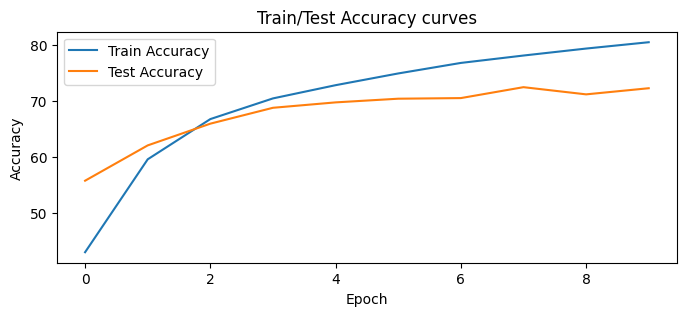

In [90]:
# Plot accuracy curves
plt.figure(figsize=(8, 3))
plt.plot(epoch, train_accuracies_history, label="Train Accuracy")
plt.plot(epoch, test_accuracies_history, label="Test Accuracy")
plt.title("Train/Test Accuracy curves")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend();

### 8. Making predictions

In [91]:
def make_predictions(model, data, device):
  pred_probs = []
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for sample in data:
      sample = torch.unsqueeze(sample, dim = 0).to(device)
      pred_logit = model(sample)
      pred_prob = torch.softmax(pred_logit.squeeze(), dim = 0)
      pred_probs.append(pred_prob.cpu())

  return torch.stack(pred_probs)

In [92]:
import random
# random.seed(42)

test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data), k = 15):
  test_samples.append(sample)
  test_labels.append(label)

In [93]:
# Make Predictions
pred_probs = make_predictions(model,
                              test_samples,
                              device)

# Convert prediction proabbilities to labels
pred_classes = pred_probs.argmax(dim=1)
print(pred_classes, test_labels, sep = '\n')

tensor([0, 2, 2, 0, 4, 9, 2, 2, 4, 2, 7, 3, 0, 2, 8])
[9, 2, 5, 0, 0, 9, 2, 2, 3, 4, 7, 3, 0, 7, 8]


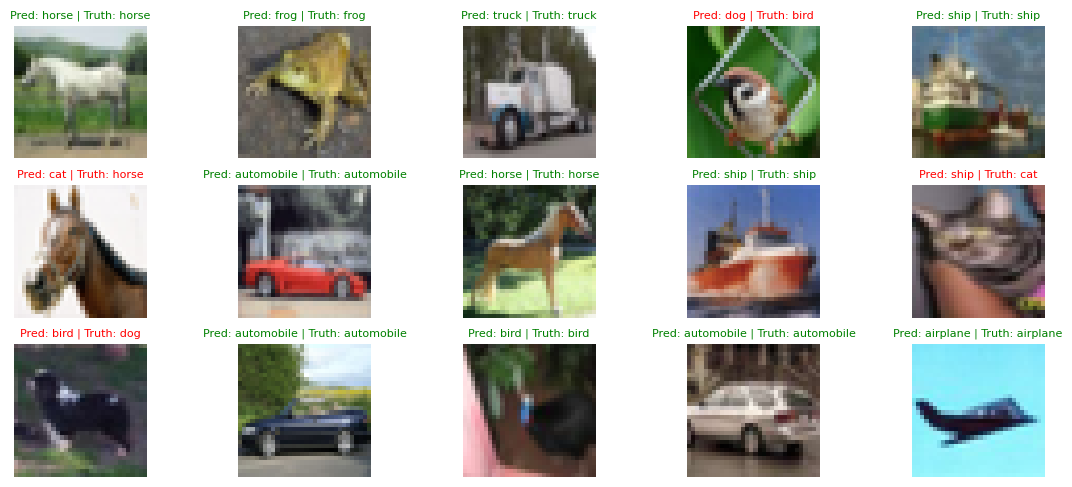

In [85]:
# Plot predictions
plt.figure(figsize = (14, 10))
nrows, ncols = 5, 5
for i, sample in enumerate(test_samples):
  plt.subplot(nrows, ncols, i+1)
  plt.imshow(np.transpose(sample, (1, 2, 0)))

  pred_label = class_name[pred_classes[i]]
  truth_label = class_name[test_labels[i]]
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  # Check equality between pred and truth and change color of title
  if pred_label == truth_label:
    plt.title(title_text, fontsize = 8, c="g")
  else:
    plt.title(title_text, fontsize = 8, c="r")

  plt.axis(False);

### 9. Plotting Confusion Matrix

In [98]:
from tqdm.auto import tqdm

# Make prediciton with trained model
y_preds = []
model.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader,
                   desc = "Making predictions...\t"):
    X, y = X.to(device), y.to(device)
    y_logits = model(X)
    y_pred = torch.softmax(y_logits.squeeze(), dim = 0).argmax(dim = 1 )
    y_preds.append(y_pred.cpu())

# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)
y_pred_tensor[:10], len(y_pred_tensor)

Making predictions...	:   0%|          | 0/313 [00:00<?, ?it/s]

(tensor([8, 3, 4, 5, 6, 4, 7, 2, 2, 0]), 10000)

In [99]:
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

mlxtend version: 0.22.0


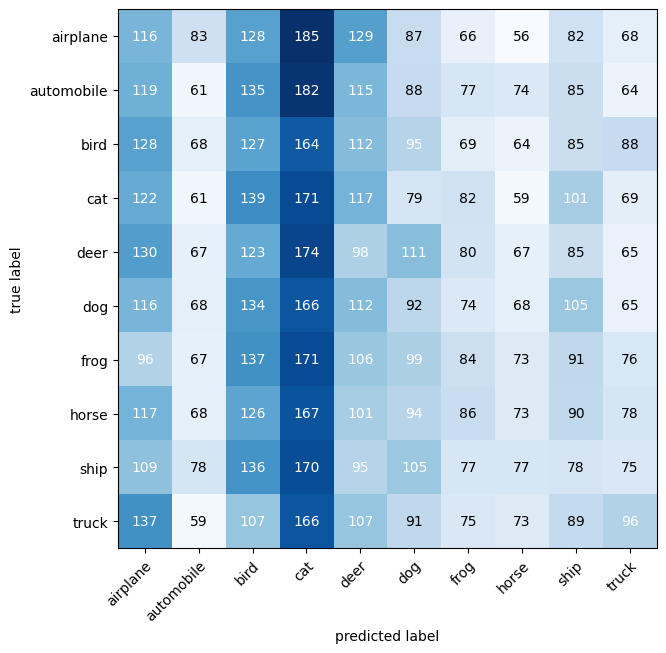

In [106]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(num_classes = len(class_name), task = 'multiclass')
# print(y_pred_tensor, test_data.targets)
confmat_tensor = confmat(preds = y_pred_tensor,
                         target = torch.tensor(test_data.targets))

# Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat = confmat_tensor.numpy(),
    class_names = class_name,
    figsize = (10, 7)
);